# Monitoring Training with TensorBoard

When we train a model, we often focus on the final validation accuracy. But in practice, it’s just as important to **monitor the model during training**:

- How quickly is the model learning?
- Is it overfitting?
- Are the weights and activations behaving as expected?

TensorBoard is a powerful tool that allows us to **visualize training dynamics** in real time. We can track:

- Loss and accuracy over epochs
- Histograms of weights and biases
- Layer activations
- Comparisons between multiple training runs

In this notebook, we will:

1. Load the 5-flowers dataset using `tensorflow_datasets`.
2. Prepare a lightweight computer vision model (MobileNetV2-based).
3. Train the model locally on CPU while logging metrics for TensorBoard.
4. Launch TensorBoard to explore the model’s learning behavior.

By the end of this notebook, you will be able to **interpret training curves and monitor your models**, which is essential for debugging and improving production-ready models.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import os
import matplotlib.pyplot as plt

# Load and Preprocess Dataset

IMG_SIZE = 224
BATCH_SIZE = 32

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare Lightweight Model

# Use MobileNetV2 as a feature extractor
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

# Add classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [2]:
# Set Up TensorBoard Logging

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,        # record weight histograms
    write_graph=True,        # record computation graph
    write_images=True        # save model weights as images
)

print(f"TensorBoard logs will be saved to: {log_dir}")


TensorBoard logs will be saved to: logs/fit/20260217-083337


In [ ]:
# Train Model with Logging

EPOCHS = 3  # lightweight demo for CPU

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)


Epoch 1/3
92/92 [==============================] - 34s 333ms/step - loss: 0.7599 - accuracy: 0.7149 - val_loss: 0.4500 - val_accuracy: 0.8569
Epoch 2/3
92/92 [==============================] - 27s 295ms/step - loss: 0.4025 - accuracy: 0.8587 - val_loss: 0.3805 - val_accuracy: 0.8828
Epoch 3/3
92/92 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8893

In [6]:
# Launch TensorBoard inline in Jupyter

%load_ext tensorboard

%tensorboard --logdir logs/fit

# NOTE: You can instead run the following commands within an Anaconda PowerShell terminal window do start TensorBoard
# --> conda activate cv
# --> cd Documents/cv/08_quality
# --> tensorboard --logdir logs/fit
# After running those commands, you can then open http://localhost:6006/ in your web browser to access TensorBoard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12356), started 0:00:43 ago. (Use '!kill 12356' to kill it.)

## What to Explore in TensorBoard:
- Scalars: track training & validation loss/accuracy
- Histograms: see weight distributions change over epochs
- Graphs: visualize model layers
- Comparisons: if you train multiple models, you can see differences in curves

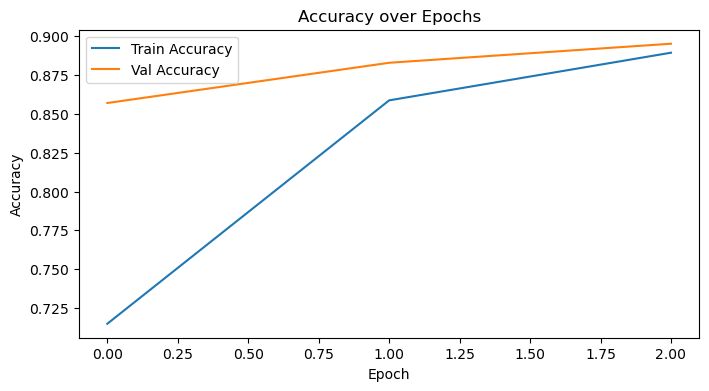

In [7]:
# Optional: Plot Training History Locally

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()
